In [1]:
import numpy as np
import pandas as pd
import testsolver
import testTOVsolver
import TOVsolver
import matplotlib.pyplot as plt

In [2]:
# read in our EOS data
# The files contain n[0.16 fm^-3], p[Mev/fm^-3] and eps [Mev/fm^-3]

EOS_1 = pd.read_table('../data/3952.dat', header=None).to_numpy()
EOS_2 = pd.read_table('../data/8663.dat', header=None).to_numpy()
EOS_3 = pd.read_table('../data/13022.dat', header=None).to_numpy()

In [3]:
R_3952_test, M_3952_test, L_3952_test = testsolver.tov_solve(EOS_1[:,2], EOS_1[:,1])
# R_8663_test, M_8663_test, L_8663_test = testsolver.tov_solve(EOS_2[:,2], EOS_2[:,1])
# R_13022_test, M_13022_test, L_13022_test = testsolver.tov_solve(EOS_3[:,2], EOS_3[:,1])

In [4]:
MRL_3952_test = testTOVsolver.solve(EOS_1)
MRL_3952 = TOVsolver.solve(EOS_1)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_3952[:,1], MRL_3952[:,0], 'o', label='my sovler')
ax[0].plot(MRL_3952_test[:,1], MRL_3952_test[:,0], label='my sovler test')
ax[0].plot(R_3952_test, M_3952_test, label='not my sovler')

ax[1].plot(MRL_3952[:,0], MRL_3952[:,2], label='my sovler')
ax[1].plot(MRL_3952_test[:,0], MRL_3952_test[:,2], label='my sovler test')
ax[1].plot(M_3952_test, L_3952_test, label='not my sovler')
ax[1].set_yscale('log')
plt.legend()

In [ ]:
EOS = np.loadtxt('../data/poly3EOS/1605.dat')

In [ ]:
MRL = TOVsolver.solve(EOS)
MRL_test = testTOVsolver.solve(EOS)
R_test, M_test, L_test = testsolver.tov_solve(EOS[:,2], EOS[:,1])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

# ax[0].plot(MRL[:,1], MRL[:,0], 'o', label='my sovler')
ax[0].plot(MRL_test[:,1], MRL_test[:,0], label='my sovler test')
ax[0].plot(R_test, M_test, 'o', label='not my sovler')
ax[0].legend()

ax[1].plot(MRL[:,0], MRL[:,2], label='my sovler')
ax[1].plot(M_test, L_test, 'o', label='not my sovler')
ax[1].set_yscale('log')


In [10]:
def extend_cs(ns, starts, cs2_func, n_step=None, size=None):
    """
    Function to extend the EOS by using linear segments in speed of sound

    Inputs:
    n_step: int defining step size in density
    ns: array containing the densities where segments begin/end
    starts: array containing the starting values for the EOS (density, pressure, energy)
    cs2_func: linear interpolation of randomly sampled speed of sound values

    Outputs:
    EOS_ex: array of shape (size, 3) containing the values for EOS extension
    """

    if size == None:
        size = int((ns[-1] - starts[0]) / n_step)
    elif type(size) == int:
        n_step = (ns[-1] - starts[0]) / size
    else:
        print("Please enter a value for `rho_step` or `size`")
        return

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0, 0] = starts[0]
    EOS_ex[0, 1] = starts[1]
    EOS_ex[0, 2] = starts[2]

    for k in range(size - 1):
        # n_i+1
        EOS_ex[k + 1, 0] = EOS_ex[k, 0] + n_step
        # p_i+1
        if cs2_func(EOS_ex[k, 0]) > 1:
            EOS_ex[k + 1, 1] = EOS_ex[k, 1] + n_step * ((EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])
        else:
            EOS_ex[k + 1, 1] = EOS_ex[k, 1] + n_step * (cs2_func(EOS_ex[k, 0])) * (
                        (EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])
        # e_i+1
        EOS_ex[k + 1, 2] = EOS_ex[k, 2] + n_step * ((EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])

    return EOS_ex

def stitch_EOS(small_EOS, EOS_ex):
    """
    Function to stitch EOS extension to original EOS

    Inputs:
    small_EOS: array containing original EOS
    EOS_ex: array containing EOS extension

    Outputs:
    tot_EOS: array containing total EOS
    """
    # get relevant sizes
    size_smol = small_EOS.shape[0] - 1  # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]

    # initialize array
    tot_EOS = np.zeros((size_smol + size_ex, small_EOS.shape[1]))

    tot_EOS[:size_smol, :] = small_EOS[:size_smol, :]
    tot_EOS[size_smol:, 0] = EOS_ex[:, 0]
    tot_EOS[size_smol:, 1] = EOS_ex[:, 1]
    tot_EOS[size_smol:, 2] = EOS_ex[:, 2]

    return tot_EOS

n0 = 0.16 #MeV/fm^3

In [23]:
import scipy.interpolate

EOS_start = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

starts = np.array([EOS_start[-1,0], EOS_start[-1,1], EOS_start[-1,2]])

ns = np.array([0.32,1.06680562,1.46538581,1.5191516,1.55891299,1.6,6.4])
cs = np.array([0.36540786, 0.09235523, 0.20378882, 0.87353809, 0.02005543, 0.50045754, 0.3333333])
cs2_func = scipy.interpolate.interp1d(ns, cs ** 2)
          
EOS_ex = extend_cs(ns, starts, cs2_func, size=int(1e4))

EOS_test = stitch_EOS(EOS_start, EOS_ex)

In [26]:
import time
start_t = time.time()
MRL = TOVsolver.solve(EOS_test)
print(time.time()-start_t)


15.473005056381226


In [27]:
start_t = time.time()
R_test, M_test, L_test = testsolver.tov_solve(EOS_test[:,2], EOS_test[:,1])
print(time.time()-start_t)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/brendanking/Documents/LANL_project/test_stuff/testsolver.py:114: RuntimeWarning: invalid value encountered in log
  den = 2 * C * a1 + 4 * (C ** 3) * a2 + 3 * ((1 - 2 * C) ** 2) * a3 * np.log(1 - 2 * C)


32.22693610191345


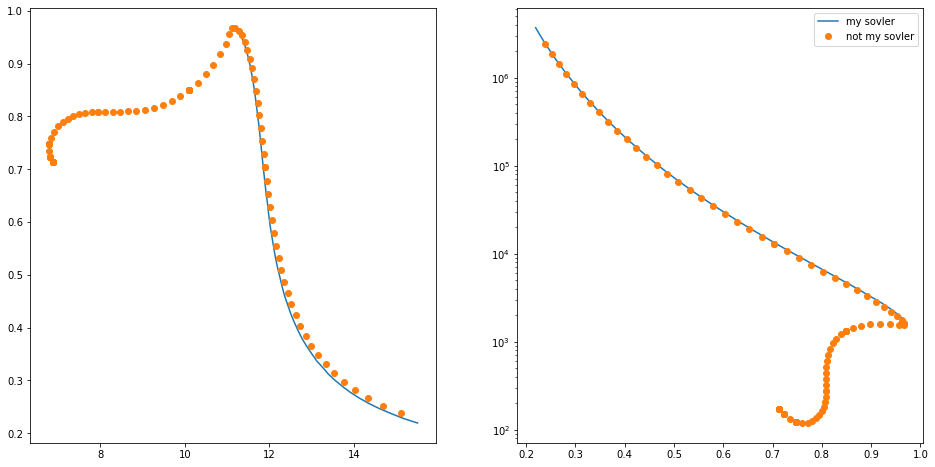

In [25]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL[:,1], MRL[:,0], label='my sovler')
ax[0].plot(R_test, M_test, 'o', label='not my sovler')

ax[1].plot(MRL[:,0], MRL[:,2], label='my sovler')
ax[1].plot(M_test, L_test, 'o', label='not my sovler')
ax[1].set_yscale('log')
plt.legend()